# Lab1: Decision Tree Classifier
Titanic Survival Prediction

## Dependencies

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import plot_tree

# check scikit-learn version
from sklearn import __version__ as ver
print(f"scikit-learn version: {ver}")

scikit-learn version: 1.4.1.post1


## Data

### Load the Data

In [2]:
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)

### Explore the Data

In [3]:
# target
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 1309 entries, 0 to 1308
Series name: survived
Non-Null Count  Dtype   
--------------  -----   
1309 non-null   category
dtypes: category(1)
memory usage: 1.5 KB


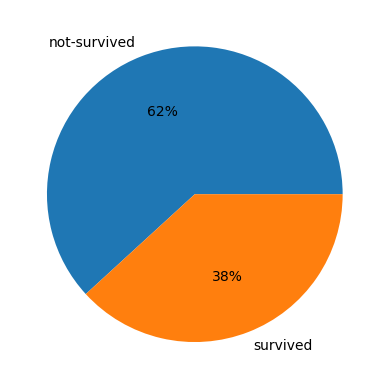

In [4]:
plt.pie (y.value_counts(), labels=['not-survived', 'survived'], autopct='%1.0f%%')
plt.show()

In [5]:
# Features
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   pclass     1309 non-null   int64   
 1   name       1309 non-null   object  
 2   sex        1309 non-null   category
 3   age        1046 non-null   float64 
 4   sibsp      1309 non-null   int64   
 5   parch      1309 non-null   int64   
 6   ticket     1309 non-null   object  
 7   fare       1308 non-null   float64 
 8   cabin      295 non-null    object  
 9   embarked   1307 non-null   category
 10  boat       486 non-null    object  
 11  body       121 non-null    float64 
 12  home.dest  745 non-null    object  
dtypes: category(2), float64(3), int64(3), object(5)
memory usage: 115.4+ KB


### Remove Irrelevant Columns

In [6]:
# drop unnecessary columns
X.drop(["name", "ticket", "cabin", "boat", "body", "home.dest"], axis=1, inplace=True)
X.head()

,pclass,sex,age,sibsp,parch,fare,embarked
0,1,female,29.0000,0,0,211.3375,S
1,1,male,0.9167,1,2,151.5500,S
2,1,female,2.0000,1,2,151.5500,S
3,1,male,30.0000,1,2,151.5500,S
4,1,female,25.0000,1,2,151.5500,S


### Impute Missing Values

In [7]:
# handling missing values
X["age"].fillna(X["age"].median(), inplace=True)
X["fare"].fillna(X["fare"].median(), inplace=True)
X["embarked"].fillna(X["embarked"].mode()[0], inplace=True)

### Feature Encoding
- conver categorical features to numerical

In [8]:
le = LabelEncoder()
X["sex"] = le.fit_transform(X["sex"])
X["embarked"] = le.fit_transform(X["embarked"])

### Describe the Data

In [9]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
pclass,1309.0,2.294882,0.837836,1.0000,2.0000,3.0000,3.000,3.0000
sex,1309.0,0.644003,0.478997,0.0000,0.0000,1.0000,1.000,1.0000
age,1309.0,29.503183,12.905246,0.1667,22.0000,28.0000,35.000,80.0000
sibsp,1309.0,0.498854,1.041658,0.0000,0.0000,0.0000,1.000,8.0000
parch,1309.0,0.385027,0.865560,0.0000,0.0000,0.0000,0.000,9.0000
fare,1309.0,33.281086,51.741500,0.0000,7.8958,14.4542,31.275,512.3292
embarked,1309.0,1.493506,0.814244,0.0000,1.0000,2.0000,2.000,2.0000


### Examine Feature Correlations

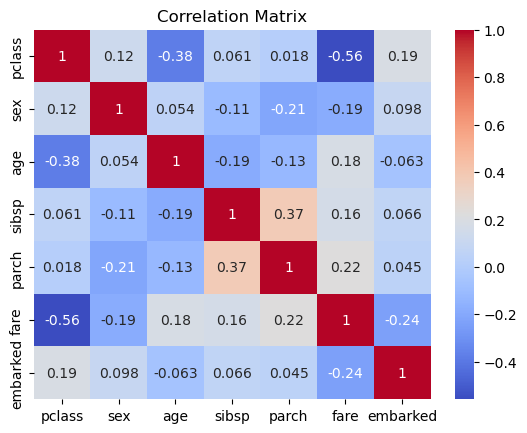

In [10]:
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

## Model
- Decision Tree Classifier
- https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier

### Train the Model

In [11]:
# split the data for training and testing the model
random_state = 123
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=random_state)

In [12]:
clf = DecisionTreeClassifier(random_state=random_state)
clf.fit(X_train, y_train)
print(f"Train accuracy: {clf.score(X_train, y_train):.3f}")
print(f"Test accuracy: {clf.score(X_test, y_test):.3f}")

Train accuracy: 0.969
Test accuracy: 0.746


In [13]:
yhat = clf.predict(X_test)
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.79      0.81      0.80       243
           1       0.67      0.65      0.66       150

    accuracy                           0.75       393
   macro avg       0.73      0.73      0.73       393
weighted avg       0.74      0.75      0.74       393



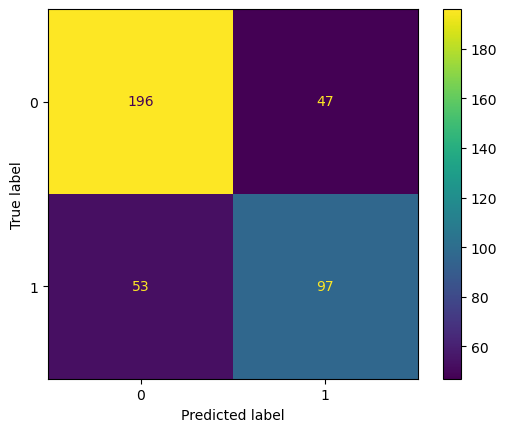

In [14]:
cm = confusion_matrix(y_test, yhat)
cm_display = ConfusionMatrixDisplay(cm).plot()

### Feature Importances

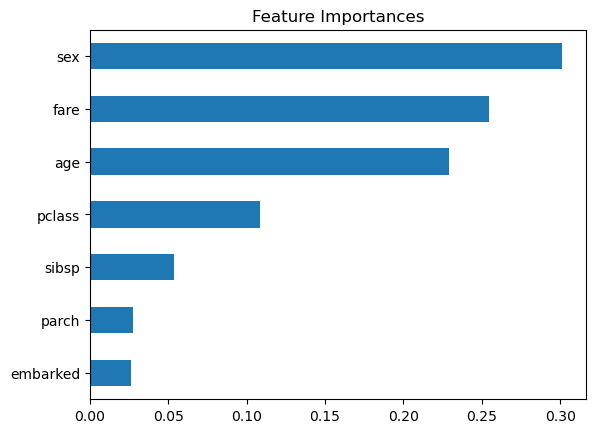

In [15]:
feature_names = X_train.columns

importances = pd.Series(
    clf.feature_importances_, index=feature_names
).sort_values(ascending=True).plot.barh()
plt.title('Feature Importances')
plt.show()

### Tree Structure

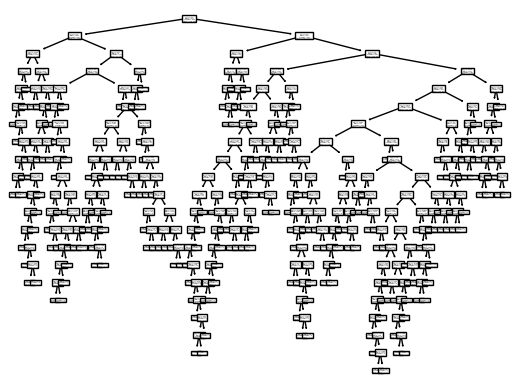

Decision Tree Depth: 20
Decision Tree Node Count: 419


In [16]:
plot_tree(clf)
plt.show()
print(f"Decision Tree Depth: {clf.get_depth()}")
print(f"Decision Tree Node Count: {clf.tree_.node_count}")

### Tree Pruning

Number of nodes in the last tree is: 1 with ccp_alpha: 0.13108492683468448


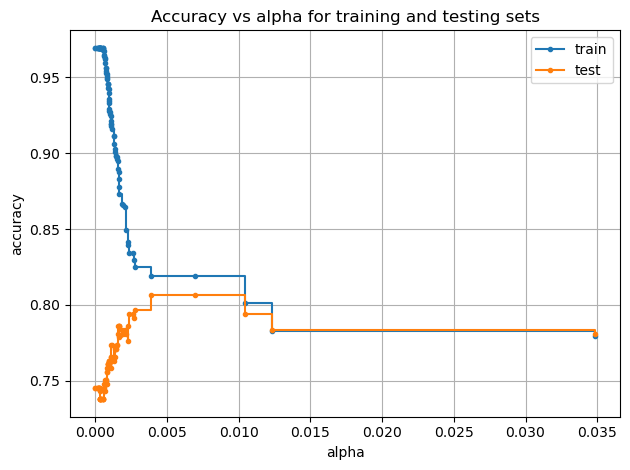

In [17]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Wee train a decision tree using the effective alphas. The last value
# in ``ccp_alphas`` is the alpha value that prunes the whole tree,
# leaving the tree, ``clfs[-1]``, with one node.
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=random_state, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

# We remove the last element in ``clfs`` and ``ccp_alphas``, 
# because it is the trivial tree with only one node. 
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

# Accuracy vs alpha for training and testing sets
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='.', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='.', label="test", drawstyle="steps-post")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

When ``ccp_alpha`` is set to zero and keeping the other default parameters
of :class:`DecisionTreeClassifier`, the tree overfits, leading to
a 97% training accuracy and 75% testing accuracy. As alpha increases, more
of the tree is pruned, thus creating a decision tree that generalizes better.
In this example, setting ``ccp_alpha=[0.004, 0.01]`` maximizes the testing accuracy.

### Retrain with Pruning

In [18]:
clf = DecisionTreeClassifier(random_state=random_state, ccp_alpha=0.01)
clf.fit(X_train, y_train)
print(f"Train accuracy: {clf.score(X_train, y_train):.3f}")
print(f"Test accuracy: {clf.score(X_test, y_test):.3f}")

Train accuracy: 0.819
Test accuracy: 0.807


In [19]:
print(f"Decision Tree Depth: {clf.get_depth()}")
print(f"Decision Tree Node Count: {clf.tree_.node_count}")

Decision Tree Depth: 3
Decision Tree Node Count: 11


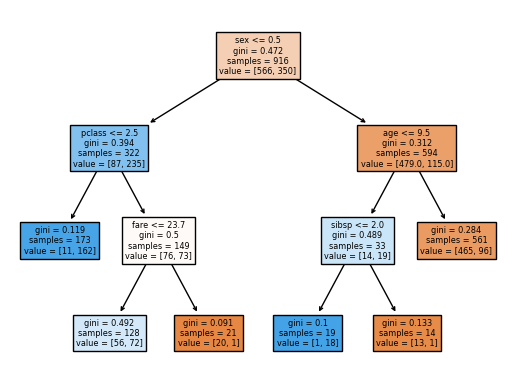

In [20]:
plot_tree(clf, feature_names=feature_names, filled=True)
plt.show()

### Evaluate

In [21]:
yhat = clf.predict(X_test)
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.83      0.86      0.85       243
           1       0.76      0.72      0.74       150

    accuracy                           0.81       393
   macro avg       0.80      0.79      0.79       393
weighted avg       0.81      0.81      0.81       393



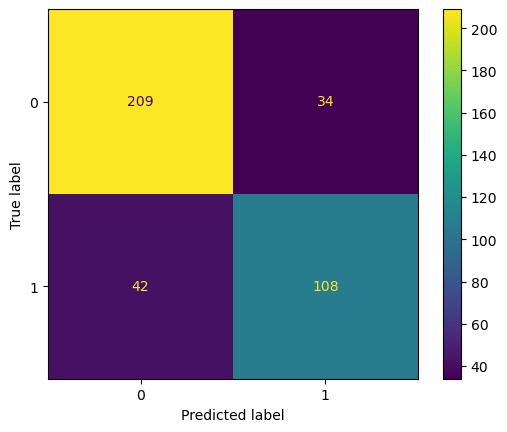

In [22]:
cm = confusion_matrix(y_test, yhat)
cm_display = ConfusionMatrixDisplay(cm).plot()

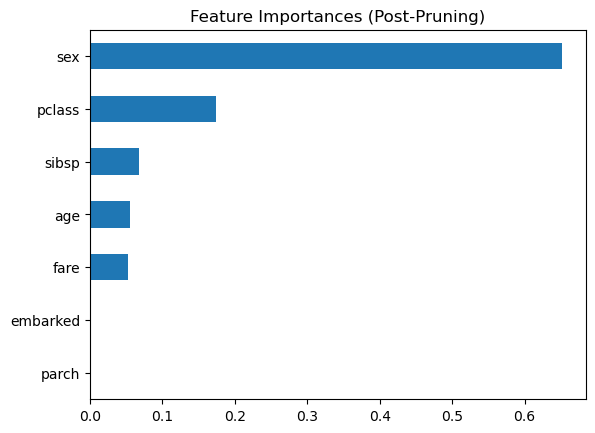

In [24]:
importances = pd.Series(
    clf.feature_importances_, index=feature_names
).sort_values(ascending=True)
importances.plot.barh()
plt.title('Feature Importances (Post-Pruning)')
plt.show()

In [27]:
importances

parch       0.000000
embarked    0.000000
fare        0.051947
age         0.055427
sibsp       0.067177
pclass      0.173337
sex         0.652112
dtype: float64